# Predicting Adult Height

Predicting adult height with a simple linear model. Also playing with a bayesian linear model just so I can better see the uncertainity. (Yes all heights are in inches)

In [1]:
import numpy as np
import pymc3 as pm
import pandas as pd
import statsmodels.formula.api as smf
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as graph
from IPython.display import display, Markdown

graph.style.use('fivethirtyeight')

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
/home/stephen/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
df = pd.read_csv('data/GaltonFamilies.csv', index_col=0)
df['isMale'] = (df['gender'] == 'male').astype(int)

print(df.shape)
display(df.head())

(934, 9)


,family,father,mother,midparentHeight,children,childNum,gender,childHeight,isMale
1,001,78.5,67.0,75.43,4,1,male,73.2,1
2,001,78.5,67.0,75.43,4,2,female,69.2,0
3,001,78.5,67.0,75.43,4,3,female,69.0,0
4,001,78.5,67.0,75.43,4,4,female,69.0,0
5,002,75.5,66.5,73.66,4,1,male,73.5,1


In [3]:
print(f'Number of families = {len(df.family.unique())}')

Number of families = 205


/home/stephen/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


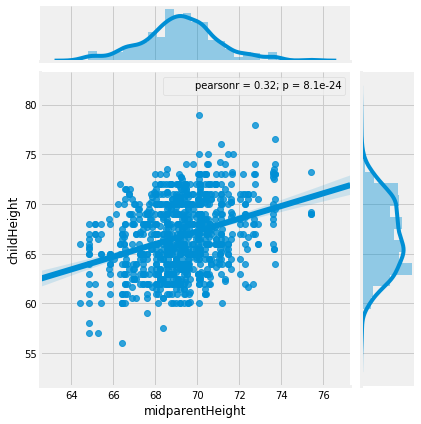

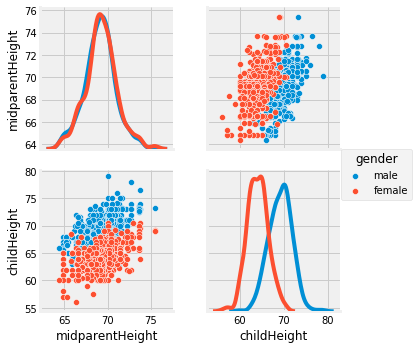

In [4]:
sns.jointplot(df['midparentHeight'], df['childHeight'], kind='reg')
graph.show()

sns.pairplot(data=df[['midparentHeight', 'childHeight', 'gender']], hue='gender', diag_kind='kde')
graph.show()

# Model the problem

In [5]:
df.columns

Index(['family', 'father', 'mother', 'midparentHeight', 'children', 'childNum',
       'gender', 'childHeight', 'isMale'],
      dtype='object')

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            childHeight   No. Observations:                  934
Model:                            GLM   Df Residuals:                      930
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:               4.685886962145977
Method:                          IRLS   Log-Likelihood:                -2044.6
Date:                Wed, 16 May 2018   Deviance:                       4357.9
Time:                        14:13:22   Pearson chi2:                 4.36e+03
No. Iterations:                     2                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            16.5212      2.727      6.058      0.000      11.176      21.866
C(gender)[T.male]     5.2150      0.142     36.775      0.000       4.937       5.493
father                0.3928      0.029     13.699      0.000       0.337       0.449
mother                0.3176      0.031     10.245      0.000       0.257       0.378
=====================================================================================
"""

/home/stephen/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


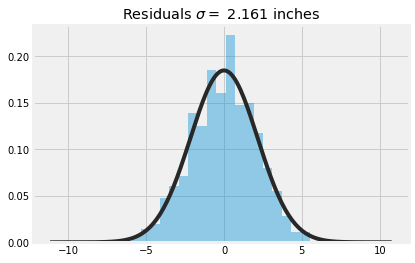

CPU times: user 357 ms, sys: 149 ms, total: 506 ms
Wall time: 573 ms


In [6]:
%%time
# Frequentist GLM
fglm = smf.glm('childHeight ~ father + mother + C(gender)', data=df).fit()

display(fglm.summary())

graph.title(f'Residuals $\sigma =$ {fglm.resid_pearson.std():0.3f} inches')
sns.distplot(fglm.resid_pearson, fit=stats.norm, kde=False)
graph.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/stephen/miniconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [male, mother, father, b, error_interval__]
  0%|          | 0/10500 [00:00<?, ?it/s]INFO (theano.gof.compilelock): Waiting for existing lock by process '30554' (I am process '30556')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/stephen/.theano/compiledir_Linux-4.13--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.4-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '30554' (I am process '30557')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/stephen/.theano/compiledir_Linux-4.13--generic-

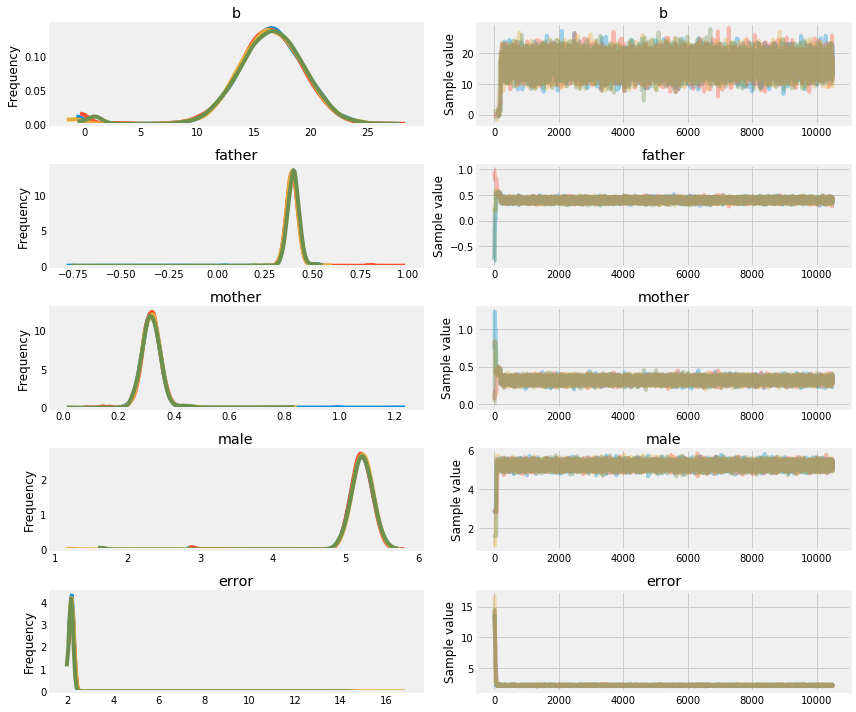

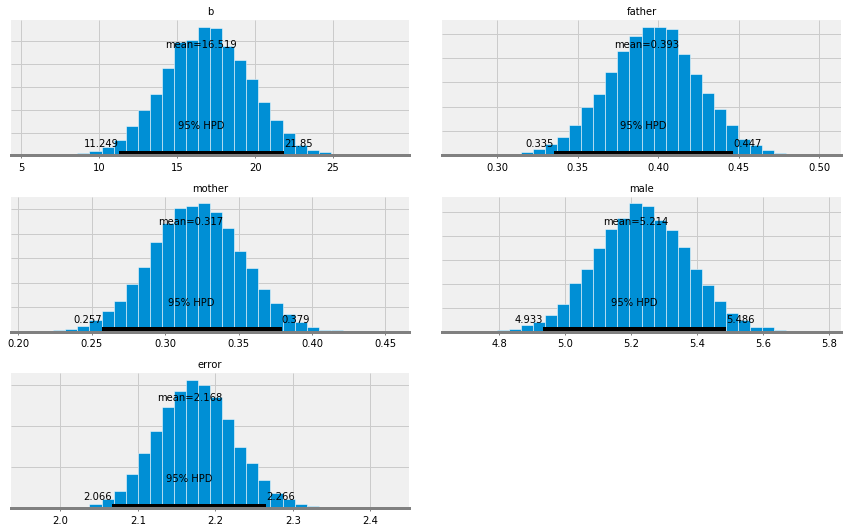

CPU times: user 9.29 s, sys: 3.55 s, total: 12.8 s
Wall time: 5min 16s


In [7]:
%%time
with pm.Model() as bayes_regression:
    # Priors Bayesian GLM
    # childHeight ~ father + mother + C(gender)
    error = pm.Uniform('error', lower=0, upper=25)
    b = pm.Normal('b', mu=0, sd=100**2)
    father = pm.Normal('father', mu=0, sd=100**2)
    mother = pm.Normal('mother', mu=0, sd=100**2)
    male = pm.Normal('male', mu=2, sd=100**2)
    
    # Model
    obs = pm.Normal(
        'y', 
        mu=(father * df['father']) + (mother * df['mother']) + (male * df['isMale']) + b, sd=error,
        observed=df['childHeight']
    )
    
    # Sample
    trace = pm.sample(int(10e3), n_init=1000, discard_tuned_samples=False)
    
    # Posterior
    pm.traceplot(trace)
    graph.show()
    
    trace = trace[1000::3]  # Verified with autocorrelation plots
    
    pm.plot_posterior(trace)
    graph.show()

100%|██████████| 100/100 [00:01<00:00, 91.00it/s]


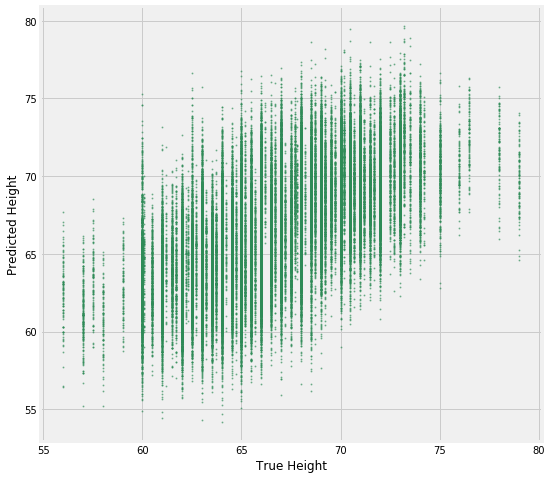

In [8]:
# Predictive Posterior Checks
graph.figure(figsize=(8, 8))
for row in zip(df['childHeight'], pm.sample_ppc(trace, samples=100, model=bayes_regression)['y'].T):
    graph.plot(row[0] * np.ones(row[1].shape), row[1], 'o', markersize=1, color='seagreen', alpha=0.5)
graph.xlabel('True Height')
graph.ylabel('Predicted Height')
graph.show()

# Getting Predictions From Models

In [9]:
def create_point(mom, dad, gender):
    p = pd.DataFrame(
        {'mother': mom, 'father': dad, 'gender': 'female' if 'f' in gender else 'male'},
        index=[0]
    )
    p['isMale'] = (p['gender'] == 'male').astype(int)
    return p

In [11]:
def point_estimate(mom, dad, gender):
    """Frequentist single point estimate"""
    point = create_point(mom, dad, gender)
    return fglm.predict(point)[0]

display(Markdown(f'Anthony estimated at {point_estimate(62, 67, "m"):0.2f} inches'))

Anthony estimated at 67.75 inches

In [12]:
# Posterior parameters
trace_df = pm.trace_to_dataframe(trace)
display(trace_df.head(3))

,b,father,mother,male,error
0,15.851452,0.405010,0.311733,5.338206,2.168131
1,17.217030,0.365153,0.338926,5.151582,2.144571
2,18.756083,0.381971,0.295651,4.915094,2.256691


/home/stephen/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


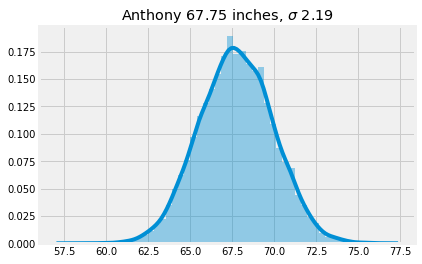

In [13]:
def bayes_estimate(mom, dad, gender):
    point = create_point(mom, dad, gender)
    est = []
    for _, row in trace_df.iterrows():
        p = ((row['father'] * point['father']) + (row['mother'] * point['mother']) + (row['male'] * point['isMale']) + row['b'])
        p += stats.norm.rvs(loc=0, scale=row['error'], size=1)
        est.append(p)
    return np.array(est).flatten()

# Test Values
anthony = bayes_estimate(62, 67, 'm')
graph.title(f'Anthony {anthony.mean():0.2f} inches, $\sigma$ {anthony.std():0.2f}')
sns.distplot(anthony)
graph.show()

# Great!

type in heights and gender below to play with predictions

/home/stephen/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


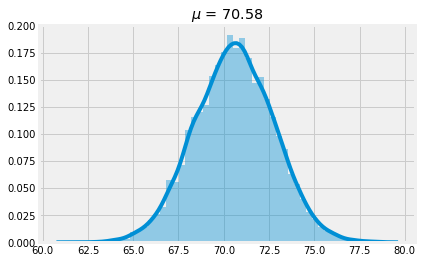

In [14]:
test_point = bayes_estimate(71, 67, 'm')
graph.title(f'$\mu$ = {test_point.mean():0.2f}')
sns.distplot(test_point)
graph.show()